## 26x26のウエハに限定して機械学習させる
- データオーギュメンテーション（鏡映，回転を追加）

### import，入力データの読み込み

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/LSWMD.pkl


In [2]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 


import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

datapath = join('data', 'wafer')

print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

using GPU: 0,1


Using TensorFlow backend.


['LSWMD.pkl']


### データについて

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- データセットは811,457枚のウエハマップから構成されている．

- ウエハマップのそれぞれの列から得られる情報はないが，インスタンスごとにダイサイズが異なることがわかる．
- ウエハマップのダイサイズをチェックするための変数`WaferMapDim`を定義する．（縦，横の値）

In [4]:
df = df.drop(['waferIndex'], axis = 1)

In [5]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
803898,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",895.0,lot47234,[[Test]],[[none]],"(33, 35)"
567734,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot35598,[],[],"(32, 29)"
60631,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1287.0,lot4778,[],[],"(41, 41)"
241818,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",793.0,lot15061,[[Training]],[[Edge-Ring]],"(32, 32)"
445015,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot27293,[],[],"(33, 33)"


- 不良パターンと学習orテストラベルを数値で表す．

In [6]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [7]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [8]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

### 26x26のデータに対して処理

In [9]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [10]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [11]:
mask_x = np.zeros((24, 24))
dummy_x = cv2.resize(x[0], (24,24))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 24,24))

In [12]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


- 26x26のウエハが14366枚抽出できた．

- none の中身を見る（不良なのか，正常なのか）

In [13]:
'''
# plot 1st data
index = np.where(y == 'none')
#print(index[0])

for i in index[0]:
    print(i)
    plt.imshow(x[i])
    plt.show()

    # check faulty case
    print('Faulty case : {} '.format(y[i]))
'''

"\n# plot 1st data\nindex = np.where(y == 'none')\n#print(index[0])\n\nfor i in index[0]:\n    print(i)\n    plt.imshow(x[i])\n    plt.show()\n\n    # check faulty case\n    print('Faulty case : {} '.format(y[i]))\n"

- 最初のデータを可視化してみる．
- その前に，26x26のデータでおかしなものを表示

In [14]:
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        print(str(i) + " is error")
        #print(error)

6267 is error
6268 is error
6269 is error
6270 is error
6271 is error
6272 is error
6273 is error
6274 is error
6275 is error
6276 is error
6277 is error
6278 is error
6279 is error
6280 is error
6281 is error
6282 is error


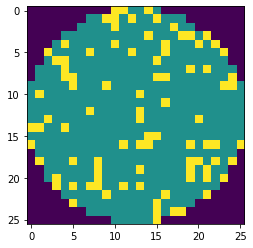

Faulty case : ['none'] 


In [15]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

- おかしなウエハは除去する

In [16]:
error_list = []
for i in range(len(x)):
    error = np.where((x[0] != x[i]) & ((x[0] == 0) | (x[i] == 0)))
    if len(error[0]) > 0:
        error_list.append(i)
x = np.delete(x, error_list, 0)
y = np.delete(y, error_list, 0)
print(x.shape)
print(y.shape)

(14350, 26, 26)
(14350, 1)


- 形が異なるウエハを削除したところ，14350枚となった．

In [17]:
x = x.reshape((-1, 26, 26, 1))
x.shape

(14350, 26, 26, 1)

In [18]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [19]:
faulty_case_dict =dict()

In [20]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 289
Edge-Ring : 23
Loc : 297
Near-full : 16
Random : 74
Scratch : 71
none : 13489


- 14366枚の26x26ウエハの不良パターンは上記のようになっている．

In [21]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [22]:
new_x.shape

(14350, 26, 26, 3)

- new_xを(14366, 26, 26, 3)とし，最後の次元にはウエハの値(0, 1, 2)がそれぞれの値毎にベクトルとしてまとめられている．
- ウエハデータの各ピクセルは，0:ウエハなし，1:正常，2:不良を表す．

### オートエンコーダで学習

#### エンコーダとデコーダのモデルを学習

- モデルの定義をする．

In [23]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [24]:
ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_______________________________________________________

- 層は
    - 入力層
    - 畳み込み層
    - プーリング層
    - 転置畳み込み層
    - アップサンプリング層

In [25]:
epoch=30
batch_size=1024

- 学習を開始する．
- `new_x`を`new_x`にエンコードしデコードする．

In [26]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=1)

Epoch 1/30
14350/14350 [==============================] - 2s 109us/step - loss: 0.1561
Epoch 2/30
14350/14350 [==============================] - 1s 39us/step - loss: 0.0968
Epoch 3/30
14350/14350 [==============================] - 1s 40us/step - loss: 0.0838
Epoch 4/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0727
Epoch 5/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0638
Epoch 6/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0570
Epoch 7/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0513
Epoch 8/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0462
Epoch 9/30
14350/14350 [==============================] - 1s 41us/step - loss: 0.0411
Epoch 10/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0361
Epoch 11/30
14350/14350 [==============================] - 1s 42us/step - loss: 0.0318
Epoch 12/30
14350/14350 [==========================

- エンコーダだけのモデルを定義する．

In [27]:
encoder = models.Model(input_tensor, latent_vector)

- デコーダだけのモデルを定義する．

In [28]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

- `encoder`を使って元のウエハ画像をエンコードする．

In [29]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

- エンコードされた潜伏的な不良ウエハにノイズを負荷する．

In [30]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

- 元のウエハ画像

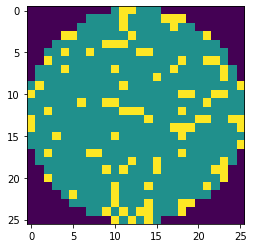

In [31]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

- マスクの定義

In [32]:
# 0がウエハ領域，1が範囲外
mask = new_x[0, :, :, 0].copy()
#out_region = np.where(mask == 1.0)
#in_region = np.where(mask == 0.0)
#mask[out_region] = 0.0
#mask[in_region] = 1.0
#print(mask)

- 回転の実験

90度ごとなら自作OpenCV関数が有用

- 90度以外の回転

In [33]:
from PIL import Image
def rotation_pil_mask(img, degree):
    src = Image.fromarray(np.uint8(img))
    img_rotate = np.array(src.rotate(degree))
    
    #before
    '''
    plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree before")
    plt.show()
    '''
    
    #マスクの適用, 
    out_region = np.where((np.argmax(img_rotate, axis=2) != 0) & (mask > 0.0))
    img_rotate[out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(img_rotate, axis=2) == 0) & (mask == 0.0))
    img_rotate[in_region[0], in_region[1]] = np.array([0., 1., 0.])

    #after
    '''plt.imshow(np.argmax(img_rotate, axis=2))
    plt.title("rotate " + str(degree) + " degree after")
    plt.show()'''

    return img_rotate

In [34]:
'''
wafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)
#plt.imshow(np.argmax(wafer[0], axis=2))
#plt.show()

print(wafer[0].shape)

for i in range(19):
    rotation_pil_mask(wafer[0], i*20)
'''

'\nwafer = new_x[np.where(y=="Edge-Loc")[0]].reshape(len(np.where(y=="Edge-Loc")[0]), 26, 26, 3)\n#plt.imshow(np.argmax(wafer[0], axis=2))\n#plt.show()\n\nprint(wafer[0].shape)\n\nfor i in range(19):\n    rotation_pil_mask(wafer[0], i*20)\n'

- ノイズが付加されたウエハ画像

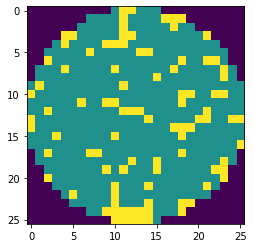

In [35]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

### データオーギュメンテーション

- データオーギュメンテーションを行う関数を定義する．
- 鏡映，回転を行う

In [36]:
# augment function define (add rotate, flip)
def gen_data(wafer, label):
    # Encode input wafer
    #encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    aug_x = np.zeros((1, 26, 26, 3))
    
    #datagen = ImageDataGenerator(rotation_range = 90, horizontal_flip = True, vertical_flip = True, fill_mode = 'constant', cval = 0)
    #datagen = ImageDataGenerator(rotation_range = 0)
    ite = 20 if label != 'none' else 1
    for i in range(len(wafer)):
        for j in range(ite):
#             data = wafer[i]
            if label != 'none':
                data = rotation_pil_mask(wafer[i], j*18)
            else:
                data = rotation_pil_mask(wafer[i], j*180)
            data = data.reshape(1, 26, 26, 3)
            aug_x = np.concatenate((aug_x, data), axis = 0)
            '''
            for j, img in enumerate(data):
                plot_num = j+1
                plt.subplot(4, 5, plot_num)
                plt.tick_params(labelbottom=False)
                plt.tick_params(labelleft=False)
                plt.imshow(img)
            plt.show()
            '''
    aug_x = aug_x[1:]
    encoded_x = encoder.predict(aug_x)
    print(encoded_x.shape)
        
    
    # Make wafer until total # of wafer to 15000
    if label != 'none':
        for i in range((13000//len(encoded_x)) + 1):
            noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
#             noised_encoded_x = encoded_x
            noised_gen_x = decoder.predict(noised_encoded_x)
            gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    else:
        gen_x = aug_x
        
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

- データオーギュメンテーション（ノイズ付加）したものが適切か調べる

一番左が元画像
右がデータオーギュメンテーション後

In [37]:
# backup
bu_new_x = new_x.copy()
bu_y = y.copy()

In [38]:
# new_x = bu_new_x.copy()
# y = bu_y.copy()
# gen_x = []

- 不良ラベルが付いているデータに対してデータオーギュメンテーションを行う．

In [39]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    #if f == 'none' : 
    #    continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

(1800, 13, 13, 64)
(20, 13, 13, 64)
(5780, 13, 13, 64)
(460, 13, 13, 64)
(5940, 13, 13, 64)
(320, 13, 13, 64)
(1480, 13, 13, 64)
(1420, 13, 13, 64)
(13489, 13, 13, 64)


In [40]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (144398, 26, 26, 3), new_y shape : (144398, 1)


In [41]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
new_y = y

Center : 14490
Donut : 13021
Edge-Loc : 17629
Edge-Ring : 13363
Loc : 18117
Near-full : 13136
Random : 13394
Scratch : 14271
none : 26977


In [42]:
np.where(new_y=='Center')[1]

array([0, 0, 0, ..., 0, 0, 0])

- ノイズ付加後におかしなデータがあるかチェック
- 元データとずれがあるもの：1689枚

### ノイズ付加後もマスクで直す

In [43]:
backup_new_x = new_x.copy()
backup_new_y = new_y.copy()

In [44]:
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)

for i in range(len(new_x)):
    #マスクの適用, 
    out_region = np.where((np.argmax(new_x[i], axis=2) != 0) & (mask > 0.0))
    new_x[i, out_region[0], out_region[1]] = np.array([1., 0., 0.])
    in_region = np.where((np.argmax(new_x[i], axis=2) == 0) & (mask == 0.0))
    new_x[i, in_region[0], in_region[1]] = np.array([0., 1., 0.])
    
count = 0
for i in range(len(new_x)):
    error = np.where((np.argmax(new_x[0], axis=2) != np.argmax(new_x[i], axis=2)) & (np.argmax(new_x[0], axis=2) == 0))
    if len(error[0]) > 0:
        #print(str(i) + "error")
        #print(error)
        count += 1
print(count)


'''plt.imshow(np.argmax(new_x[14397], axis=2))
plt.show()
plt.imshow(np.argmax(new_x[0], axis=2))
plt.show()'''

93927
0


'plt.imshow(np.argmax(new_x[14397], axis=2))\nplt.show()\nplt.imshow(np.argmax(new_x[0], axis=2))\nplt.show()'

- データオーギュメンテーションを行った結果，各不良データごとに約40000枚に増えた．
- 合計は368112枚となった．

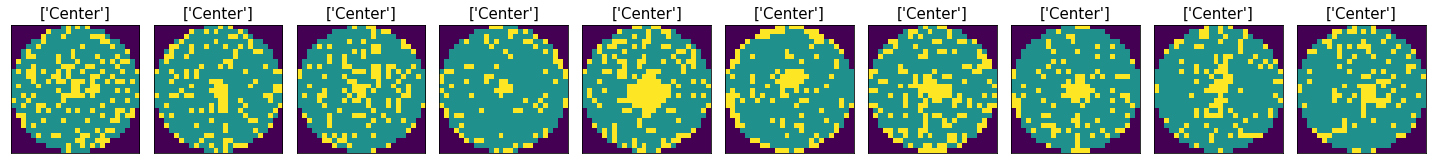

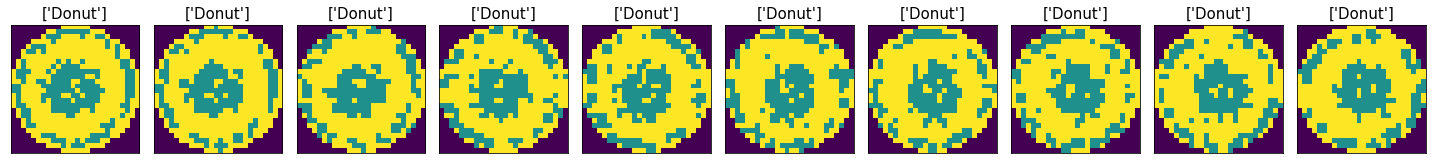

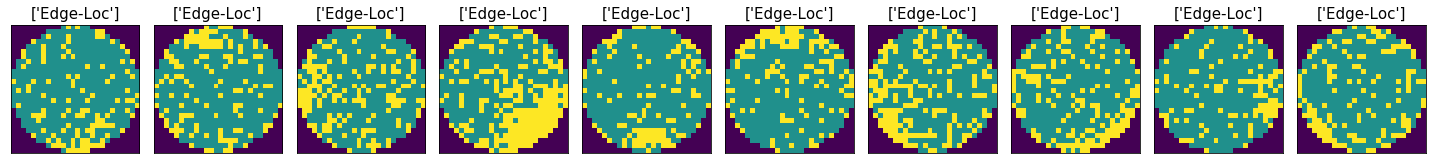

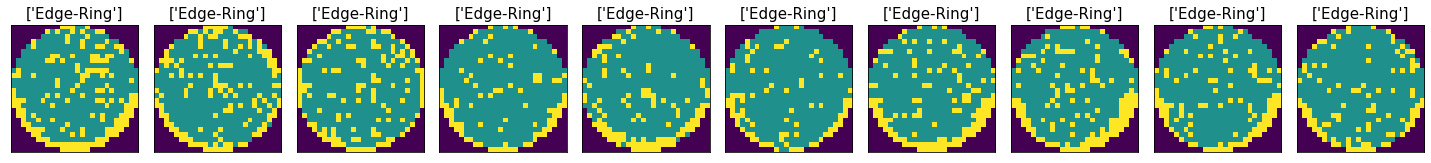

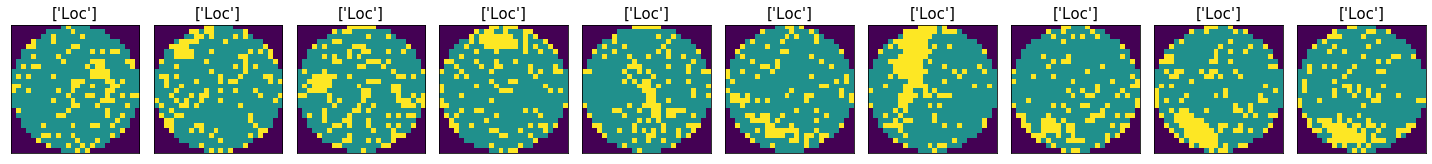

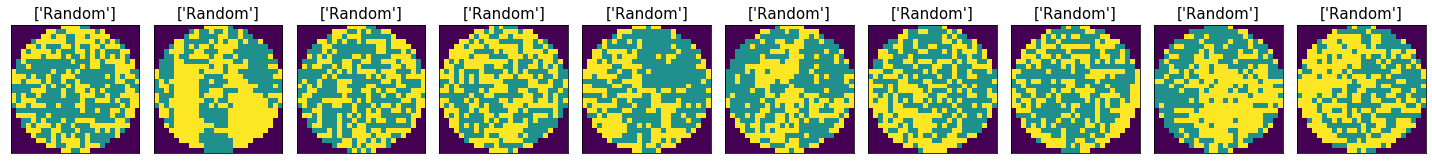

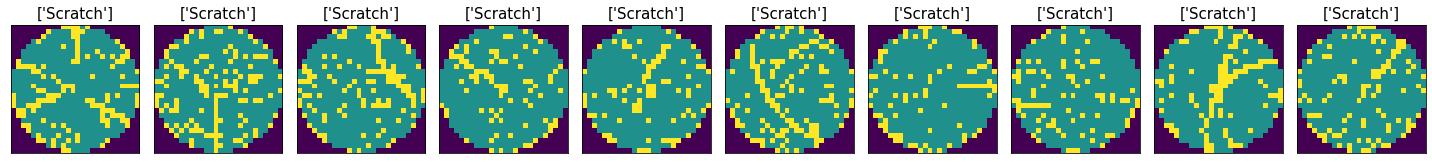

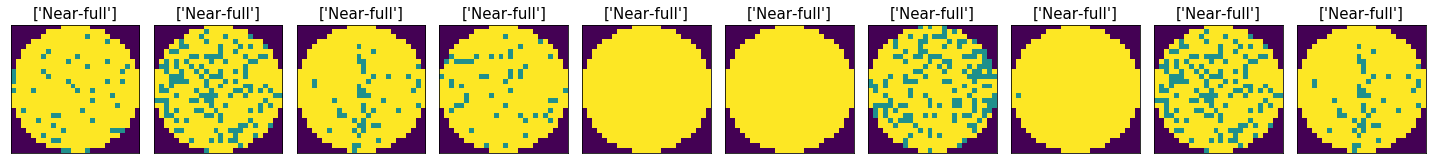

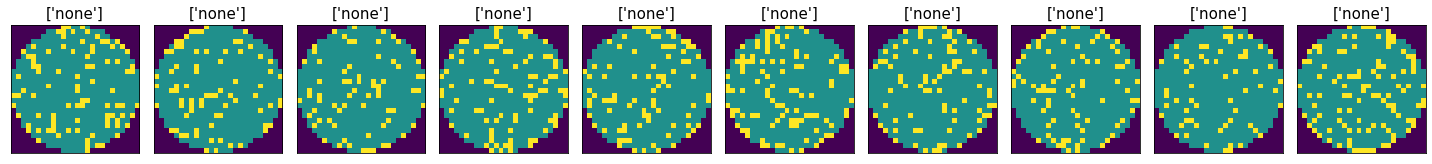

In [45]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(20, 20))
    ax = ax.ravel(order='C')
    for j in [k]:
        index = np.where(new_y==labels2[j])[0]
        img = new_x[index]
        #img = new_x[0:10]
        for i in range(10):
            ax[i].imshow(np.argmax(img[i+0], axis=2))
            ax[i].set_title(new_y[index[i+0]], fontsize=15)
            #ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

### 学習を行う
- 不良ラベルを0-8の9次元のベクトルとして表現する．
- one-hotエンコーディングを行っている．

In [46]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i

In [47]:
# one-hot-encoding
new_y = to_categorical(new_y)

In [48]:
new_X=new_x
new_Y=new_y

- 学習データとテストデータに分割する．

In [49]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,
                                                    test_size=0.33,
                                                    random_state=2019)

In [50]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (96746, 26, 26, 3), y : (96746, 9)
Test x: (47652, 26, 26, 3), y : (47652, 9)


- 学習データ246635枚，テストデータ121477枚．

- モデルの定義を行う．

In [51]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)

def create_model():
    global input_tensor
    
    conv = layers.Conv2D(32, (3,3), activation='relu', name='conv1')(input_tensor)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding1')(conv)
    conv = layers.Conv2D(64, (3,3), activation='relu', name='conv2')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding2')(conv)
    conv = layers.Conv2D(128, (3,3), activation='relu', name='conv3')(padding)
    padding = layers.ZeroPadding2D(padding=(1, 1), name='padding3')(conv)
    conv_out = layers.Conv2D(256, (3,3), activation='relu', name='conv4')(padding)

    gap_layer = layers.GlobalAveragePooling2D(name='GAP')
    output_layer = layers.Dense(9, activation='softmax', name='output')

    aver_pool = gap_layer(conv_out)
    output_tensor = output_layer(aver_pool)

    model = models.Model(input_tensor, output_tensor)

    model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [52]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=512, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
64497/64497 [==============================] - 11s 169us/step - loss: 1.1821 - accuracy: 0.5302
Epoch 2/30
64497/64497 [==============================] - 10s 149us/step - loss: 0.7699 - accuracy: 0.6937
Epoch 3/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.6454 - accuracy: 0.7427
Epoch 4/30
64497/64497 [==============================] - 10s 149us/step - loss: 0.5937 - accuracy: 0.7617
Epoch 5/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.5520 - accuracy: 0.7781
Epoch 6/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.5432 - accuracy: 0.7828
Epoch 7/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.5068 - accuracy: 0.7974
Epoch 8/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.4943 - accuracy: 0.8046
Epoch 9/30
64497/64497 [==============================] - 10s 150us/step - loss: 0.4865 - accuracy: 0.8103
Epoch 10/30
64497/64497 [============

Epoch 16/30
64498/64498 [==============================] - 10s 159us/step - loss: 0.3685 - accuracy: 0.8636
Epoch 17/30
64498/64498 [==============================] - 10s 160us/step - loss: 0.3686 - accuracy: 0.8662
Epoch 18/30
64498/64498 [==============================] - 10s 158us/step - loss: 0.3532 - accuracy: 0.8704
Epoch 19/30
64498/64498 [==============================] - 10s 159us/step - loss: 0.3286 - accuracy: 0.8794
Epoch 20/30
64498/64498 [==============================] - 10s 160us/step - loss: 0.4852 - accuracy: 0.8406
Epoch 21/30
64498/64498 [==============================] - 10s 158us/step - loss: 0.3294 - accuracy: 0.8775
Epoch 22/30
64498/64498 [==============================] - 10s 158us/step - loss: 0.3157 - accuracy: 0.8848
Epoch 23/30
64498/64498 [==============================] - 10s 159us/step - loss: 0.3010 - accuracy: 0.8896
Epoch 24/30
64498/64498 [==============================] - 10s 159us/step - loss: 0.2968 - accuracy: 0.8919
Epoch 25/30
64498/64498 [===

- Cross validiationによる精度は99.10%であった．

- Cross validationなしで学習する．

In [53]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=50,
         batch_size=512,
         verbose=1
         )

Train on 96746 samples, validate on 47652 samples
Epoch 1/50
96746/96746 [==============================] - 19s 198us/step - loss: 1.0399 - accuracy: 0.5897 - val_loss: 0.9455 - val_accuracy: 0.7008
Epoch 2/50
96746/96746 [==============================] - 18s 190us/step - loss: 0.6504 - accuracy: 0.7432 - val_loss: 0.5556 - val_accuracy: 0.7758
Epoch 3/50
96746/96746 [==============================] - 18s 187us/step - loss: 0.5929 - accuracy: 0.7672 - val_loss: 0.5279 - val_accuracy: 0.7901
Epoch 4/50
96746/96746 [==============================] - 19s 192us/step - loss: 0.5141 - accuracy: 0.7967 - val_loss: 0.5223 - val_accuracy: 0.7928
Epoch 5/50
96746/96746 [==============================] - 18s 188us/step - loss: 0.4926 - accuracy: 0.8073 - val_loss: 0.4598 - val_accuracy: 0.8164
Epoch 6/50
96746/96746 [==============================] - 18s 190us/step - loss: 0.4996 - accuracy: 0.8087 - val_loss: 0.4435 - val_accuracy: 0.8346
Epoch 7/50
96746/96746 [==============================] 

- テストデータで評価．    

In [54]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

47652/47652 [==============================] - 3s 63us/step
Testing Accuracy: 0.937589168548584


- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [55]:
model.model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        896       
_________________________________________________________________
padding1 (ZeroPadding2D)     (None, 26, 26, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 64)        18496     
_________________________________________________________________
padding2 (ZeroPadding2D)     (None, 26, 26, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 24, 24, 128)       73856     
_________________________________________________________________
padding3 (ZeroPadding2D)     (None, 26, 26, 128)       0   

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

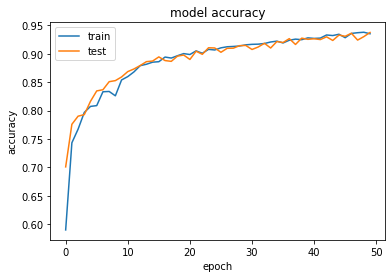

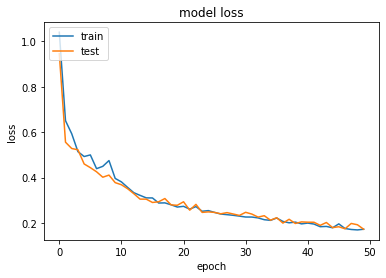

In [56]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### クラス活性化マップ

In [57]:
#set target wafer number
target_wafer_num = 2
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [58]:
aver_output = model.model.layers[7]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [59]:
weight_result = model.model.layers[-1].get_weights()[0]

In [60]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,24, 24))
    for row in range(0,9):
        cam = np.zeros((1, 24, 24))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(24,24)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [61]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

'Edge-Ring'

faulty case : Edge-Ring


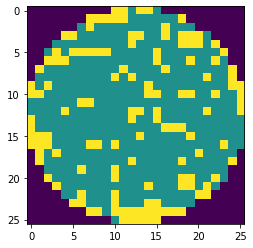

In [62]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [63]:
cam_result.shape

(1, 24, 24, 256)

In [64]:
cam_arr = make_cam(cam_result, weight_result)

In [65]:
prob.shape

(1, 9)

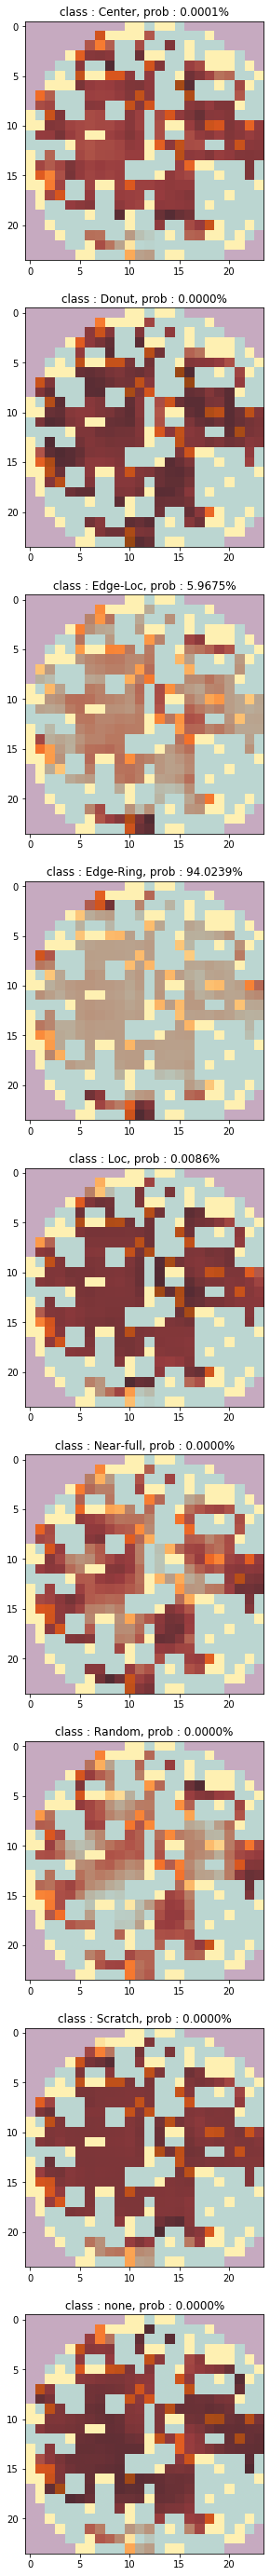

In [66]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している

### CNN

In [67]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
def create_model():


    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

- 3-Fold Cross validationで分割して学習する．

In [68]:
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=1024, verbose=1) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

Epoch 1/30
64497/64497 [==============================] - 8s 123us/step - loss: 0.9865 - accuracy: 0.6586
Epoch 2/30
64497/64497 [==============================] - 7s 109us/step - loss: 0.3162 - accuracy: 0.8833
Epoch 3/30
64497/64497 [==============================] - 7s 109us/step - loss: 0.2200 - accuracy: 0.9244
Epoch 4/30
64497/64497 [==============================] - 7s 108us/step - loss: 0.1297 - accuracy: 0.9571
Epoch 5/30
64497/64497 [==============================] - 7s 112us/step - loss: 0.0805 - accuracy: 0.9740
Epoch 6/30
64497/64497 [==============================] - 7s 109us/step - loss: 0.0509 - accuracy: 0.9846
Epoch 7/30
64497/64497 [==============================] - 7s 108us/step - loss: 0.0273 - accuracy: 0.9929
Epoch 8/30
64497/64497 [==============================] - 7s 108us/step - loss: 0.1838 - accuracy: 0.9566
Epoch 9/30
64497/64497 [==============================] - 7s 109us/step - loss: 0.0213 - accuracy: 0.9950
Epoch 10/30
64497/64497 [=====================

64498/64498 [==============================] - 7s 109us/step - loss: 1.0442 - accuracy: 0.7752
Epoch 17/30
64498/64498 [==============================] - 7s 109us/step - loss: 0.1550 - accuracy: 0.9462
Epoch 18/30
64498/64498 [==============================] - 7s 109us/step - loss: 0.0579 - accuracy: 0.9835
Epoch 19/30
64498/64498 [==============================] - 7s 108us/step - loss: 0.0241 - accuracy: 0.9945
Epoch 20/30
64498/64498 [==============================] - 7s 109us/step - loss: 0.0142 - accuracy: 0.9973
Epoch 21/30
64498/64498 [==============================] - 7s 108us/step - loss: 0.0099 - accuracy: 0.9981
Epoch 22/30
64498/64498 [==============================] - 7s 109us/step - loss: 0.0081 - accuracy: 0.9983
Epoch 23/30
64498/64498 [==============================] - 7s 109us/step - loss: 0.0082 - accuracy: 0.9981
Epoch 24/30
64498/64498 [==============================] - 7s 108us/step - loss: 0.0079 - accuracy: 0.9983
Epoch 25/30
64498/64498 [========================

- Cross validiationによる精度は99.55%であった．

- Cross validationなしで学習する．

In [69]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=1           
         )

Train on 96746 samples, validate on 47652 samples
Epoch 1/30
96746/96746 [==============================] - 13s 134us/step - loss: 0.8248 - accuracy: 0.7184 - val_loss: 0.3328 - val_accuracy: 0.8714
Epoch 2/30
96746/96746 [==============================] - 13s 130us/step - loss: 0.2478 - accuracy: 0.9106 - val_loss: 0.2071 - val_accuracy: 0.9271
Epoch 3/30
96746/96746 [==============================] - 13s 130us/step - loss: 0.1707 - accuracy: 0.9434 - val_loss: 0.1588 - val_accuracy: 0.9471
Epoch 4/30
96746/96746 [==============================] - 13s 131us/step - loss: 0.1029 - accuracy: 0.9662 - val_loss: 0.1055 - val_accuracy: 0.9650
Epoch 5/30
96746/96746 [==============================] - 13s 130us/step - loss: 0.0554 - accuracy: 0.9828 - val_loss: 0.0771 - val_accuracy: 0.9751
Epoch 6/30
96746/96746 [==============================] - 13s 131us/step - loss: 0.0312 - accuracy: 0.9915 - val_loss: 0.0705 - val_accuracy: 0.9791
Epoch 7/30
96746/96746 [==============================] 

- テストデータで評価．    

In [70]:
score = model.score(x_test, y_test)
#print('Test Loss:', score[0])
#print('Test accuracy:', score[1])
print('Testing Accuracy:',score)

47652/47652 [==============================] - 2s 42us/step
Testing Accuracy: 0.9912490844726562


- acuurayは99.70%であった．

- モデルは以下．
    - 入力層
    - 畳み込み層3つ
    - Flatten層（1次元に）
    - 全結合層3つ

In [71]:
model.model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        9280      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 86528)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               44302848  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               656

- accuracyグラフ，lossグラフは以下．
- 5epoch程度で落ち着いている．

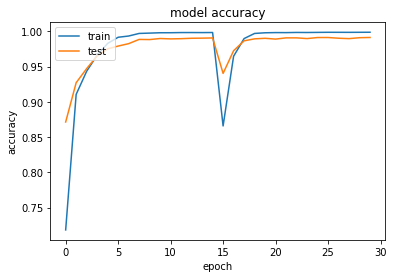

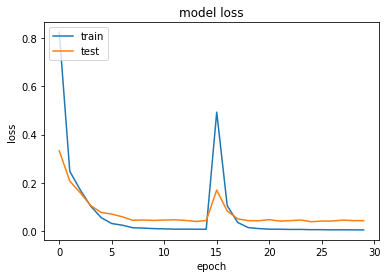

In [72]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
#y_train_pred = np.argmax(model.predict(x_train))
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
y_train_max = np.argmax(y_train, axis=1)
y_test_max = np.argmax(y_test, axis=1)

print(y_train_max[0])
print(y_train_pred[0])

train_acc2 = np.sum(y_train_max == y_train_pred, axis=0, dtype='float') / x_train.shape[0]
test_acc2 = np.sum(y_test_max == y_test_pred, axis=0, dtype='float') / x_test.shape[0]
print('Training acc: {}'.format(train_acc2*100))
print('Testing acc: {}'.format(test_acc2*100))
print("y_train_pred[:100]: ", y_train_pred[:100])
print ("y_train_max[:100]: ", y_train_max[:100])

47652/47652 [==============================] - 2s 38us/step
5
5
Training acc: 99.88526657432865
Testing acc: 99.12490556534877
y_train_pred[:100]:  [5 0 2 5 2 5 8 8 8 8 2 2 4 7 1 7 2 8 5 8 2 6 4 7 6 8 4 8 0 0 5 8 5 3 5 5 2
 8 6 3 3 4 5 1 5 2 0 2 6 0 2 7 0 7 1 2 6 0 3 2 7 8 5 4 6 7 5 2 4 0 6 6 6 4
 0 0 8 8 2 6 7 6 7 2 6 1 1 4 7 0 8 8 3 8 4 0 6 6 6 3]
y_train_max[:100]:  [5 0 2 5 2 5 8 8 8 8 2 2 4 7 1 7 2 8 5 8 2 6 4 7 6 8 4 8 0 0 5 8 5 3 5 5 2
 8 6 3 3 4 5 1 5 2 0 2 6 0 2 7 0 7 1 2 6 0 3 2 7 8 5 4 6 7 5 2 4 0 6 6 6 4
 0 0 8 8 2 6 7 6 7 2 6 1 1 4 7 0 8 8 3 8 4 0 6 6 6 3]


### 混同行列

In [74]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
Normalized confusion matrix


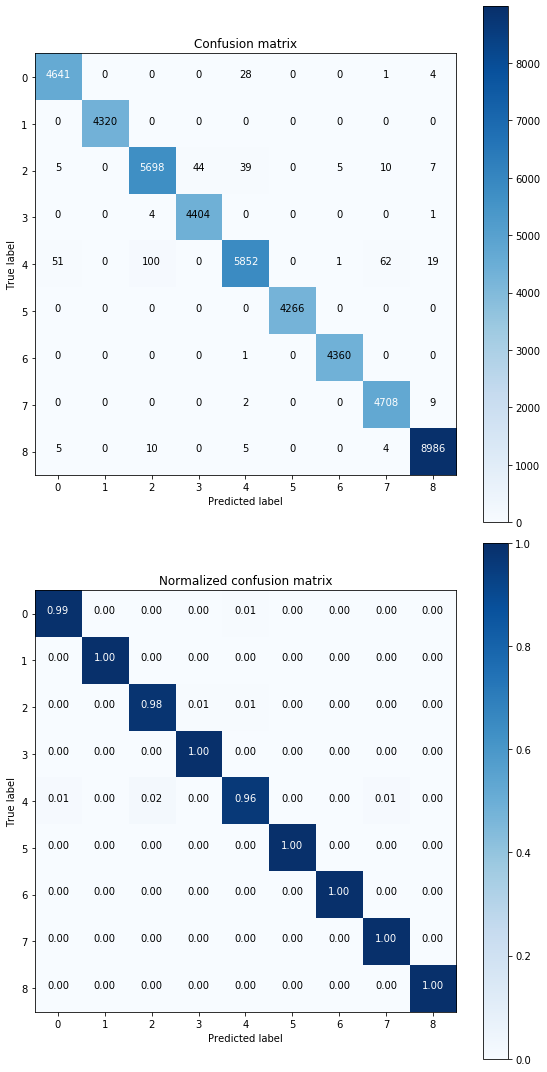

In [75]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_max, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(8, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### クラス活性化マップ

In [76]:
#set target wafer number
target_wafer_num = 10000
# predict 
prob = model.model.predict(x_test[target_wafer_num].reshape(1,26,26,3))

In [77]:
aver_output = model.model.layers[3]
aver_model = models.Model(input_tensor, aver_output.output)
cam_result = aver_model.predict(x_test[target_wafer_num].reshape(1, 26, 26, 3))

In [78]:
print(model.model.layers[3].name)

conv2d_13


In [79]:
weight_result = model.model.layers[-1].get_weights()[0]

In [80]:
def make_cam(cam_result, weight_result): 
    cam_arr = np.zeros((1,26, 26))
    for row in range(0,9):
        cam = np.zeros((1, 26, 26))
        for i, w in enumerate(weight_result[:, row]):
            cam += (w*cam_result[0,:,:,i]).reshape(26,26)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        cam[mask_x == 0] = 0
        cam_arr = np.concatenate((cam_arr, cam))
    return cam_arr[1:]

def display_activation(cam_arr, prob, wafer): 
    fig, ax = plt.subplots(9, 1, figsize=(50, 50))
    count = 0
    cam_arr[np.percentile(cam_arr, 0.8) > cam_arr] = 0
    for row in range(0,9):
        ax[row].imshow(np.argmax(wafer, axis=2))
        ax[row].imshow(cam_arr[row],cmap='Reds', alpha=0.7)
        ax[row].set_title('class : ' + faulty_case_dict[count]+', prob : {:.4f}'.format(prob[:, count][0]*100) + '%')
        count += 1

In [81]:
faulty_case_dict[np.argmax(y_test[target_wafer_num])]

'none'

faulty case : none


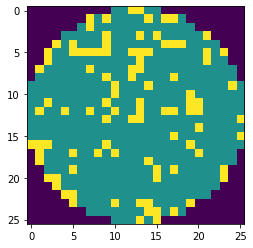

In [82]:
plt.imshow(np.argmax(x_test[target_wafer_num], axis=2))
print('faulty case : {}'.format(faulty_case_dict[np.argmax(y_test[target_wafer_num])]))

- 対象のウエハの画像と不良パターンの表示

In [83]:
cam_result.shape

(1, 26, 26, 128)

In [84]:
mask_x = np.zeros((26, 26))
dummy_x = cv2.resize(x[0], (26,26))
mask_x[dummy_x == 1] = 1 
mask_x[dummy_x == 2] = 1 
mask_x = mask_x.reshape((1, 26,26))

In [85]:
cam_arr = make_cam(cam_result, weight_result)

In [86]:
prob.shape

(1, 9)

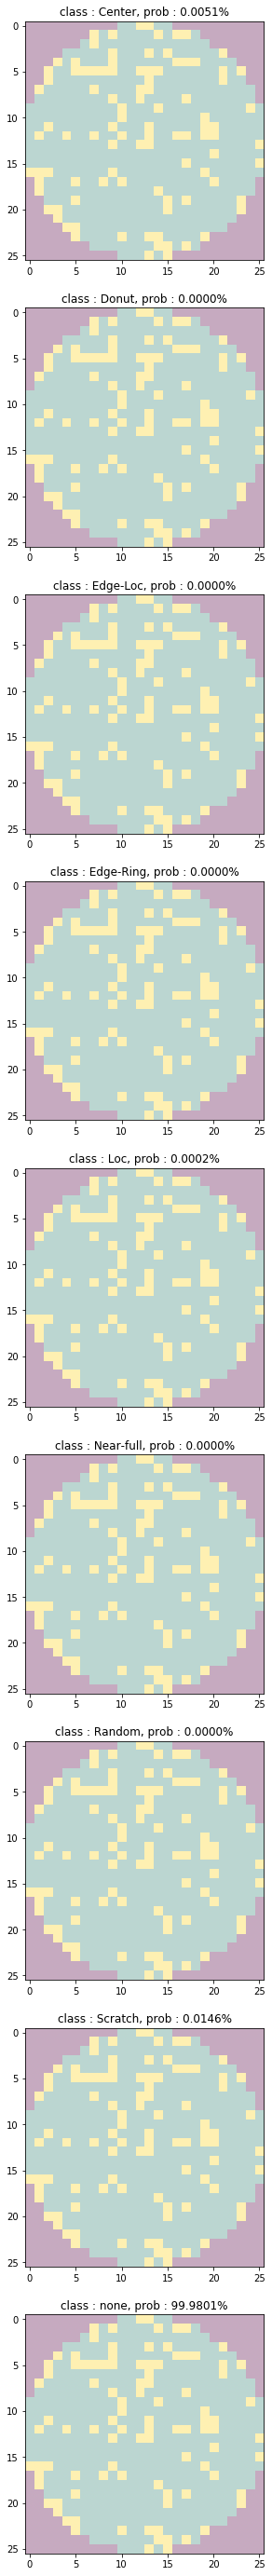

In [87]:
display_activation(cam_arr, prob, x_test[target_wafer_num])

- 活性化マップの表示
- ドーナツでは円形状にヒートマップの赤い部分が点在している